<a href="https://colab.research.google.com/github/aTh1ef/pytorch-cat-vs-dog-classifier/blob/main/cat_vs_dog_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
--2025-03-11 08:07:39--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 184.29.22.44, 2600:1406:bc00:a81::317f, 2600:1406:bc00:a8e::317f
Connecting to download.microsoft.com (download.microsoft.com)|184.29.22.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M  82.0MB/s    in 10s     

2025-03-11 08:07:50 (76.9 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]

Bad file PetImages/Cat/666.jpg: cannot identify image file 'PetImages/Cat/666.jpg'
Bad file PetImages/Cat/Thumbs.db: cannot identify image file 'PetImages/Cat/Thumbs.db'
Bad file PetImages/Dog/11702.jpg: cannot identify image file 'PetImages/Dog/11702.jpg'


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Bad file PetImages/Dog/Thumbs.db: cannot identify image file 'PetImages/Dog/Thumbs.db'
Copied 9998 cat training images
Copied 9998 dog training images
Copied 2501 cat validation images
Copied 2501 dog validation images


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 125MB/s]


Using device: cuda
Epoch 1/5 completed in 123s
Train Loss: 0.1192, Train Acc: 0.9552
Val Loss: 0.0676, Val Acc: 0.9744
------------------------------------------------------------
Epoch 2/5 completed in 120s
Train Loss: 0.0789, Train Acc: 0.9696
Val Loss: 0.0634, Val Acc: 0.9754
------------------------------------------------------------
Epoch 3/5 completed in 119s
Train Loss: 0.0769, Train Acc: 0.9702
Val Loss: 0.0574, Val Acc: 0.9782
------------------------------------------------------------
Epoch 4/5 completed in 119s
Train Loss: 0.0750, Train Acc: 0.9710
Val Loss: 0.0595, Val Acc: 0.9776
------------------------------------------------------------
Epoch 5/5 completed in 119s
Train Loss: 0.0719, Train Acc: 0.9714
Val Loss: 0.0531, Val Acc: 0.9800
------------------------------------------------------------


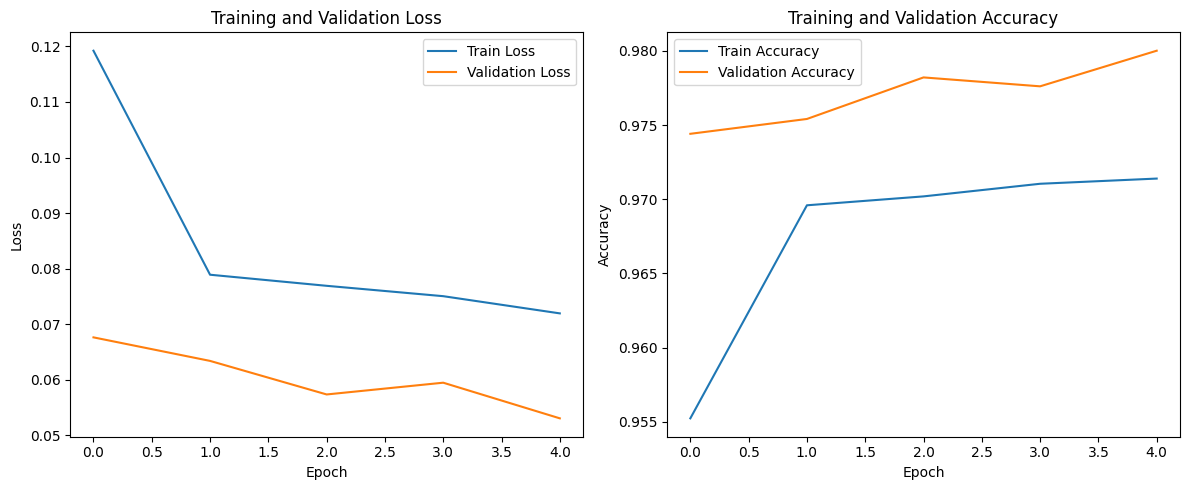

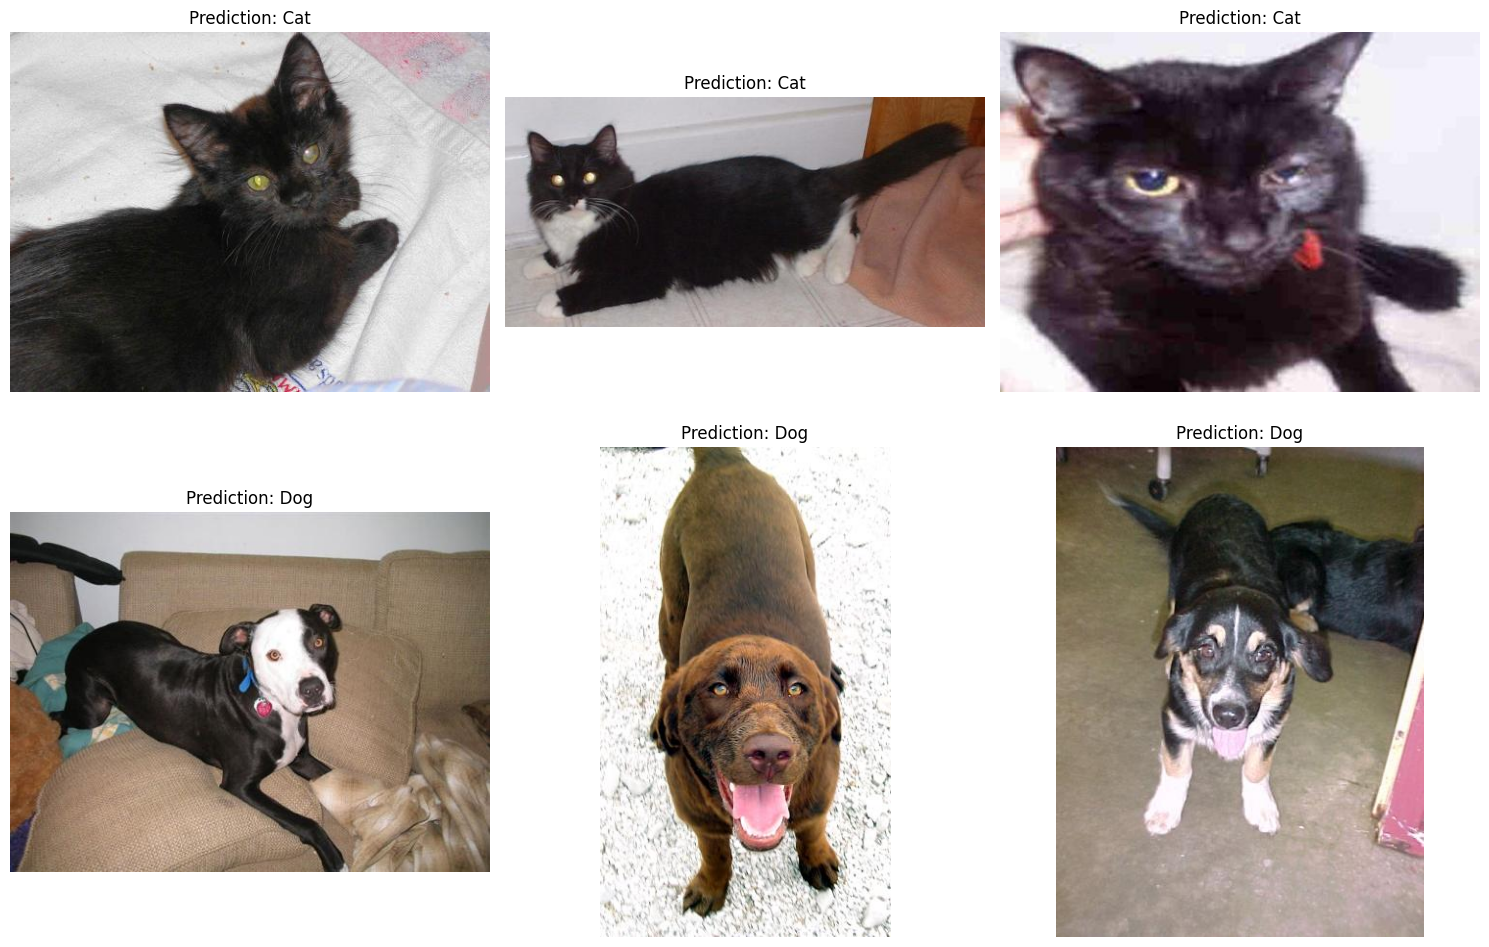

Model saved to Google Drive


In [2]:
# Dog vs Cat Classifier using PyTorch with Microsoft Dogs vs Cats dataset
# Cat vs Dog Classifier Training Code
# ==================================================================
# This cell performs the following:
# 1. Mounts Google Drive to access and save data.
# 2. Downloads and extracts the Microsoft Dogs vs Cats dataset.
# 3. Sets up the directory structure for training and validation.
# 4. Defines image transformations and loads the dataset.
# 5. Constructs a CNN model using transfer learning with ResNet18.
# 6. Trains the model, tracks performance, and visualizes results.
# 7. Saves the best and final model to Google Drive.
# ==================================================================
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import os
from google.colab import drive
from PIL import Image
import time
import shutil
import zipfile

# Mount Google Drive to access/save data
drive.mount('/content/drive')

# Download and extract the Microsoft Dogs vs Cats dataset
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -q kagglecatsanddogs_5340.zip

# Set up directory structure for PyTorch
def setup_data_directories():
    # Create directories
    os.makedirs('data/dogs_vs_cats/train/cat', exist_ok=True)
    os.makedirs('data/dogs_vs_cats/train/dog', exist_ok=True)
    os.makedirs('data/dogs_vs_cats/val/cat', exist_ok=True)
    os.makedirs('data/dogs_vs_cats/val/dog', exist_ok=True)

    # Move files from PetImages/Cat to our train and validation folders
    cat_files = os.listdir('PetImages/Cat')
    dog_files = os.listdir('PetImages/Dog')

    # Use 80% for training, 20% for validation
    cat_train_size = int(0.8 * len(cat_files))
    dog_train_size = int(0.8 * len(dog_files))

    # Move cat images
    for i, file in enumerate(cat_files):
        src = os.path.join('PetImages/Cat', file)
        # Skip corrupted images
        try:
            img = Image.open(src)
            img.verify()  # Verify it's a valid image
            if i < cat_train_size:
                dst = os.path.join('data/dogs_vs_cats/train/cat', file)
            else:
                dst = os.path.join('data/dogs_vs_cats/val/cat', file)
            shutil.copy(src, dst)
        except (IOError, SyntaxError) as e:
            print(f"Bad file {src}: {e}")
            continue

    # Move dog images
    for i, file in enumerate(dog_files):
        src = os.path.join('PetImages/Dog', file)
        # Skip corrupted images
        try:
            img = Image.open(src)
            img.verify()  # Verify it's a valid image
            if i < dog_train_size:
                dst = os.path.join('data/dogs_vs_cats/train/dog', file)
            else:
                dst = os.path.join('data/dogs_vs_cats/val/dog', file)
            shutil.copy(src, dst)
        except (IOError, SyntaxError) as e:
            print(f"Bad file {src}: {e}")
            continue

    print(f"Copied {len(os.listdir('data/dogs_vs_cats/train/cat'))} cat training images")
    print(f"Copied {len(os.listdir('data/dogs_vs_cats/train/dog'))} dog training images")
    print(f"Copied {len(os.listdir('data/dogs_vs_cats/val/cat'))} cat validation images")
    print(f"Copied {len(os.listdir('data/dogs_vs_cats/val/dog'))} dog validation images")

# Run the setup
setup_data_directories()

# Define transformations for images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

# Load datasets
train_dataset = datasets.ImageFolder(root='data/dogs_vs_cats/train', transform=transform)
val_dataset = datasets.ImageFolder(root='data/dogs_vs_cats/val', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define the model
class CatDogCNN(nn.Module):
    def __init__(self):
        super(CatDogCNN, self).__init__()

        # Use a pre-trained model for feature extraction
        self.feature_extractor = torchvision.models.resnet18(pretrained=True)

        # Freeze the parameters of the feature extractor
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

        # Replace the final fully connected layer for our binary classification
        num_features = self.feature_extractor.fc.in_features
        self.feature_extractor.fc = nn.Linear(num_features, 2)

    def forward(self, x):
        return self.feature_extractor(x)

# Create the model
model = CatDogCNN()

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    best_val_accuracy = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        start_time = time.time()

        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct / total
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = correct / total
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        # Save best model
        if epoch_val_acc > best_val_accuracy:
            best_val_accuracy = epoch_val_acc
            torch.save(model.state_dict(), '/content/drive/MyDrive/cat_dog_best_model.pth')

        time_elapsed = time.time() - start_time
        print(f'Epoch {epoch+1}/{num_epochs} completed in {time_elapsed:.0f}s')
        print(f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')
        print('-' * 60)

    return model, history

# Train the model (5 epochs to start with - you can increase for better results)
num_epochs = 5
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

# Function to predict single images
def predict_image(image_path, model, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    return predicted.item()

# Visualize some predictions
def visualize_predictions(model, transform, num_images=6):
    # Get a few random images from the validation set
    cat_val_path = 'data/dogs_vs_cats/val/cat'
    dog_val_path = 'data/dogs_vs_cats/val/dog'

    cat_images = [os.path.join(cat_val_path, f) for f in os.listdir(cat_val_path)[:num_images//2]]
    dog_images = [os.path.join(dog_val_path, f) for f in os.listdir(dog_val_path)[:num_images//2]]

    all_images = cat_images + dog_images

    plt.figure(figsize=(15, 10))

    for i, image_path in enumerate(all_images):
        if i >= num_images:
            break

        image = Image.open(image_path).convert('RGB')
        prediction = predict_image(image_path, model, transform)

        plt.subplot(2, 3, i+1)
        plt.imshow(image)
        plt.title(f"Prediction: {'Dog' if prediction == 1 else 'Cat'}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize some predictions
visualize_predictions(model, transform)

# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/cat_dog_final_model.pth')
print("Model saved to Google Drive")

Mounted at /content/drive
✅ Model file found. Loading...
✅ Model loaded successfully!


Saving images.jpg to images.jpg


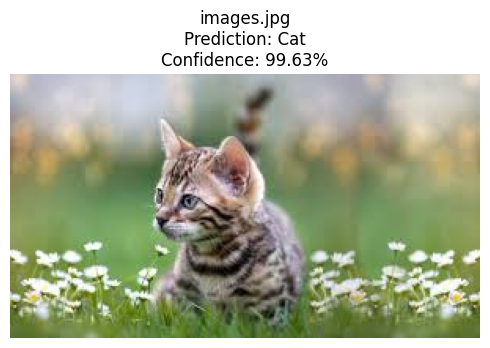

In [31]:
# Upload and test images
# 1. Run this cell to see the upload button
# 2. Select one or more image files (JPG/PNG)
# 3. The model will predict if it's a Cat or Dog and show confidence
# 4. To test more images, re-run this cell and upload again


import torch
import torchvision.models as models
import torchvision.transforms as transforms
import os
from google.colab import drive, files
from PIL import Image
import matplotlib.pyplot as plt

# ✅ 1. Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# ✅ 2. Verify if the model file exists
file_path = "/content/drive/MyDrive/cat_dog_final_model.pth"

if not os.path.exists(file_path):
    print("❌ Model file NOT found! Check the file path.")
else:
    print("✅ Model file found. Loading...")

    # ✅ 3. Define Model
    class CatDogCNN(torch.nn.Module):
        def __init__(self):
            super(CatDogCNN, self).__init__()
            self.feature_extractor = models.resnet18(weights=None)  # No pre-trained weights
            num_features = self.feature_extractor.fc.in_features
            self.feature_extractor.fc = torch.nn.Linear(num_features, 2)

        def forward(self, x):
            return self.feature_extractor(x)

    # ✅ 4. Load Model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CatDogCNN()

    model.load_state_dict(torch.load(file_path, map_location=device, weights_only=True))
    model.to(device)
    model.eval()

    print("✅ Model loaded successfully!")

    # ✅ 5. Define Image Transformations (Same as Training)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # ✅ 6. Upload & Predict Function
    def upload_and_predict():
        uploaded = files.upload()  # Upload images

        if not uploaded:
            print("❌ No images uploaded.")
            return

        num_images = len(uploaded)
        cols = min(num_images, 3)  # Max 3 columns per row
        rows = (num_images // 3) + (num_images % 3 > 0)

        plt.figure(figsize=(5 * cols, 5 * rows))  # Adjust figure size dynamically

        for i, (filename, file_data) in enumerate(uploaded.items()):
            try:
                # Save and open the image
                with open(filename, 'wb') as f:
                    f.write(file_data)
                image = Image.open(filename).convert('RGB')

                # Preprocess image
                image_tensor = transform(image).unsqueeze(0).to(device)

                # Predict
                with torch.no_grad():
                    outputs = model(image_tensor)
                    probabilities = torch.nn.functional.softmax(outputs, dim=1)
                    confidence, predicted = torch.max(probabilities, 1)

                # Get prediction label
                label = "Dog" if predicted.item() == 1 else "Cat"

                # Display image with prediction
                plt.subplot(rows, cols, i+1)
                plt.imshow(image)
                plt.title(f"{filename}\nPrediction: {label}\nConfidence: {confidence.item() * 100:.2f}%")
                plt.axis('off')

            except Exception as e:
                print(f"❌ Error processing {filename}: {e}")

        plt.tight_layout()
        plt.show()

    # ✅ 7. Run the Function
    upload_and_predict()
